In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, f1_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from imblearn.over_sampling import SMOTE

In [2]:
# 1. 数据探索（Part I）

# load data
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# 基本信息
print("="*30, "Basic info", "="*30)
print(f"train data size: {train_df.shape}")
print(f"test data size: {test_df.shape}")

# data type
print("="*30, "data type", "="*30)
print(train_df.dtypes)

print("="*30, "null cols", "="*30)
print(train_df.isnull().sum())

print("="*30, "data description", "="*30)
print(train_df.describe())

print("="*30, "depulicate row", "="*30)
print("depulicate row: ", train_df.duplicated().sum())

# 查看数据
print("="*30, "data", "="*30)
print(train_df.head())

print("="*30, "is_fraud cols stat", "="*30)
print(train_df['is_fraud'].value_counts())

============================== Basic info ==============================
train data size: (1000000, 22)
test data size: (300000, 22)
============================== data type ==============================
trans_date_trans_time     object
cc_num                     int64
merchant                  object
category                  object
amt                      float64
first                     object
last                      object
gender                    object
street                    object
city                      object
state                     object
zip                        int64
lat                      float64
long                     float64
city_pop                   int64
job                       object
dob                       object
trans_num                 object
unix_time                  int64
merch_lat                float64
merch_long               float64
is_fraud                   int64
dtype: object
============================== null cols ==============

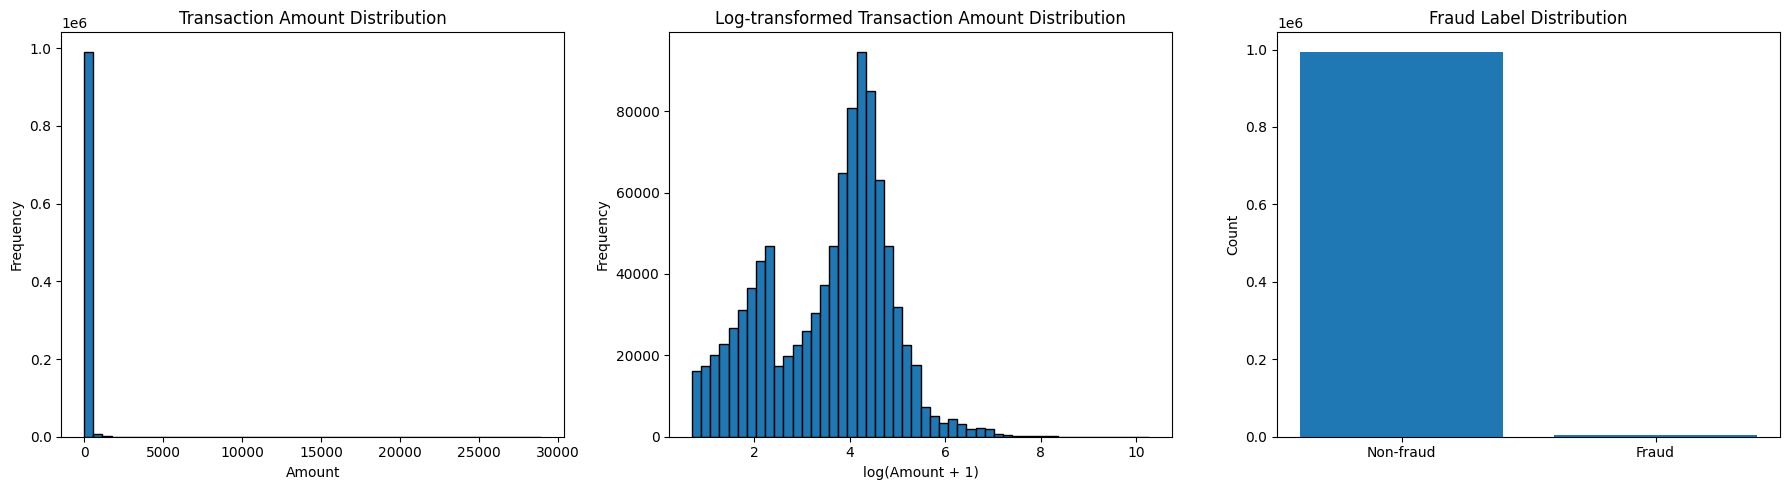

In [3]:
# 2. 数据可视化（Part I - 必须）
# 考虑可删
# Visualise target variables
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Transaction amount distribution
axes[0].hist(train_df['amt'], bins=50, edgecolor='black')
axes[0].set_title('Transaction Amount Distribution')
axes[0].set_xlabel('Amount')
axes[0].set_ylabel('Frequency')

# Log-transformed transaction amount distribution (to reduce skewness)
axes[1].hist(np.log1p(train_df['amt']), bins=50, edgecolor='black')
axes[1].set_title('Log-transformed Transaction Amount Distribution')
axes[1].set_xlabel('log(Amount + 1)')
axes[1].set_ylabel('Frequency')

# Fraud label distribution
fraud_counts = train_df['is_fraud'].value_counts()
axes[2].bar(['Non-fraud', 'Fraud'], fraud_counts.values)
axes[2].set_title('Fraud Label Distribution')
axes[2].set_ylabel('Count')

plt.tight_layout()
plt.show()


In [4]:
 # 3. 特征工程探索（Part I - 必须）
# 类别特征  category,   gender,  state,  job, city,  is_fraud
# 时间相关 trans_date_trans_time, dob, unix_time

# Data cleaning
def clean_and_prepare_data(df):
  """
    Clean and prepare the fraud dataset for modelling.
      - converts date columns
      - creates age and time-based features
      - creates distance feature
      - drops ID/leakage columns
      - casts categorical columns to 'category' dtype
    """
  df_clean = df.copy()

  # 1. Convert datetime columns
  df_clean['trans_date_trans_time'] = pd.to_datetime(df_clean['trans_date_trans_time'])
  df_clean['dob'] = pd.to_datetime(df_clean['dob'])

  # 2. Create age feature (in years) at transaction time
  df_clean['age'] = (df_clean['trans_date_trans_time'] - df_clean['dob']).dt.days / 365.25

  # 3. Time-based features from transaction datetime
  df_clean['trans_hour'] = df_clean['trans_date_trans_time'].dt.hour
  df_clean['trans_dayofweek'] = df_clean['trans_date_trans_time'].dt.dayofweek  # 0=Mon, 6=Sun
  df_clean['trans_month'] = df_clean['trans_date_trans_time'].dt.month

  # 时间特征
  df_clean['trans_day'] = df_clean['trans_date_trans_time'].dt.day
  df_clean['trans_quarter'] = df_clean['trans_date_trans_time'].dt.quarter
  
  # 4. Geo-distance feature between customer and merchant
  def haversine_np(lat1, lon1, lat2, lon2):
    R = 6371.0  # Earth radius in km
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2.0) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

  df_clean['customer_merchant_distance_km'] = haversine_np(
      df_clean['lat'], df_clean['long'], df_clean['merch_lat'], df_clean['merch_long']
  )
 
  # 距离相关特征
  df_clean['distance_log'] = np.log1p(df_clean['customer_merchant_distance_km'])
  
  # 人口特征
  df_clean['city_pop_log'] = np.log1p(df_clean['city_pop'])
  
  drop_cols = [
          'trans_date_trans_time',  # replaced by derived time features
          'dob',                    # replaced by age
          'unix_time',              # duplicate time info
          'cc_num',
          'first', 'last',
          'street',
      ]
  df_clean.drop(columns=[c for c in drop_cols if c in df_clean.columns], inplace=True)

  cat_cols = ['category', 'gender', 'state', 'job', 'merchant', 'city']
  for col in cat_cols:
      if col in df_clean.columns:
          df_clean[col] = df_clean[col].astype('category')

  return df_clean

# 4. 应用数据清理
train_clean = clean_and_prepare_data(train_df)
test_clean = clean_and_prepare_data(test_df)
print(train_clean.describe())
print("="*60)
print(train_clean.head())

                  amt             zip             lat           long  \
count  1000000.000000  1000000.000000  1000000.000000  1000000.00000   
mean        70.223098    48816.245613       38.538196      -90.22520   
std        166.281811    26850.413687        5.071274       13.73028   
min          1.000000     1257.000000       20.027100     -165.67230   
25%          9.640000    26292.000000       34.668900      -96.79800   
50%         47.430000    48174.000000       39.354300      -87.47690   
75%         83.110000    72011.000000       41.894800      -80.17520   
max      28948.900000    99921.000000       66.693300      -67.95030   

           city_pop       merch_lat      merch_long        is_fraud  \
count  1.000000e+06  1000000.000000  1000000.000000  1000000.000000   
mean   8.823559e+04       38.538365      -90.224964        0.005220   
std    3.002769e+05        5.104406       13.742489        0.072061   
min    2.300000e+01       19.027422     -166.671242        0.000000

In [5]:
# 5. 定义特征编码函数
from sklearn.preprocessing import LabelEncoder

CATEGORICAL_COLS = ['category', 'gender', 'state', 'job', 'merchant', 'city']

def encode_features(df, is_train=True, encoders=None):
    df_encoded = df.copy()

    if is_train:
        encoders = {}
        for col in CATEGORICAL_COLS:
            if col in df_encoded.columns:
                le = LabelEncoder()
                # 统一转成字符串，避免类型不一致
                values = df_encoded[col].astype(str)
                df_encoded[f'{col}_encoded'] = le.fit_transform(values)
                encoders[col] = le

        df_encoded.drop(columns=CATEGORICAL_COLS, errors='ignore', inplace=True)
        return df_encoded, encoders

    else:
        if encoders is None:
            raise ValueError("When is_train=False, encoders must be provided.")

        for col in CATEGORICAL_COLS:
            if col in df_encoded.columns and col in encoders:
                le = encoders[col]
                # 建一个「类别到编码」的字典（一次性）
                mapping = {str(cls): idx for idx, cls in enumerate(le.classes_)}
                # 向量化映射，未命中的设为 -1
                df_encoded[f'{col}_encoded'] = (
                    df_encoded[col]
                    .astype(str)
                    .map(mapping)
                    .fillna(-1)
                    .astype(int)
                )

        df_encoded.drop(columns=CATEGORICAL_COLS, errors='ignore', inplace=True)
        
        return df_encoded, encoders
# 6. 应用特征编码（
train_encoded, encoders = encode_features(train_clean, is_train=True)
test_encoded, _ = encode_features(test_clean, is_train=False, encoders=encoders)
print(train_encoded.head())

     amt    zip      lat      long  city_pop  \
0  91.04  28611  35.9946  -81.7266       885   
1   6.84  18103  40.5891  -75.4645    166081   
2  71.87  98238  48.3400 -122.3456        85   
3   6.64  79237  34.8698 -100.6806       513   
4  80.58  88325  32.9396 -105.8189       899   

                          trans_num  merch_lat  merch_long  is_fraud  \
0  505668efebf77ef6fad9d2a137797964  36.249301  -82.067591         0   
1  93a0737ce5c8af65c713e397b0a55071  41.291577  -75.682809         0   
2  1bc4614d578de1e8414c585327195f00  47.782593 -122.105325         0   
3  7f7a2923867743559594d2ded05482e5  35.790439 -101.303738         0   
4  071e51f2bd1ce429ad0769a1d6c81f25  32.134631 -106.718323         0   

         age  ...  trans_quarter  customer_merchant_distance_km  distance_log  \
0  31.389459  ...              1                      41.715077      3.754552   
1  21.593429  ...              2                      80.235270      4.397350   
2  36.177960  ...              4   

In [6]:
# 7. 准备建模数据
# 回归
feature_cols = [col for col in train_encoded.columns if col not in ['trans_num', 'is_fraud', 'amt']]
# 回归任务的特征（不包含amt）
regression_features = [f for f in feature_cols if f != 'amt']
# 回归任务
X_train_reg = train_encoded[feature_cols]
y_train_reg = train_encoded['amt']
X_test_reg = test_encoded[feature_cols]
print(f"\n完整特征列表: {feature_cols}")
print(f"\n回归任务特征数量: {len(regression_features)}")
print("regression_features: ",regression_features)



完整特征列表: ['zip', 'lat', 'long', 'city_pop', 'merch_lat', 'merch_long', 'age', 'trans_hour', 'trans_dayofweek', 'trans_month', 'trans_day', 'trans_quarter', 'customer_merchant_distance_km', 'distance_log', 'city_pop_log', 'category_encoded', 'gender_encoded', 'state_encoded', 'job_encoded', 'merchant_encoded', 'city_encoded']

回归任务特征数量: 21
regression_features:  ['zip', 'lat', 'long', 'city_pop', 'merch_lat', 'merch_long', 'age', 'trans_hour', 'trans_dayofweek', 'trans_month', 'trans_day', 'trans_quarter', 'customer_merchant_distance_km', 'distance_log', 'city_pop_log', 'category_encoded', 'gender_encoded', 'state_encoded', 'job_encoded', 'merchant_encoded', 'city_encoded']



Feature Importance Analysis

=== Regression Task ===
Fitting RandomForest on 100,000 rows for FI...

Rank Most Important Features:
                          feature  importance
6                             age    0.102926
15               category_encoded    0.091107
12  customer_merchant_distance_km    0.085011
13                   distance_log    0.080933
4                       merch_lat    0.079982
5                      merch_long    0.074115
19               merchant_encoded    0.067527
10                      trans_day    0.052510
7                      trans_hour    0.049911
3                        city_pop    0.047712
14                   city_pop_log    0.038084
20                   city_encoded    0.032779
9                     trans_month    0.030609
18                    job_encoded    0.029938
1                             lat    0.026353
2                            long    0.023089
0                             zip    0.022416
8                 trans_dayofweek    0.0

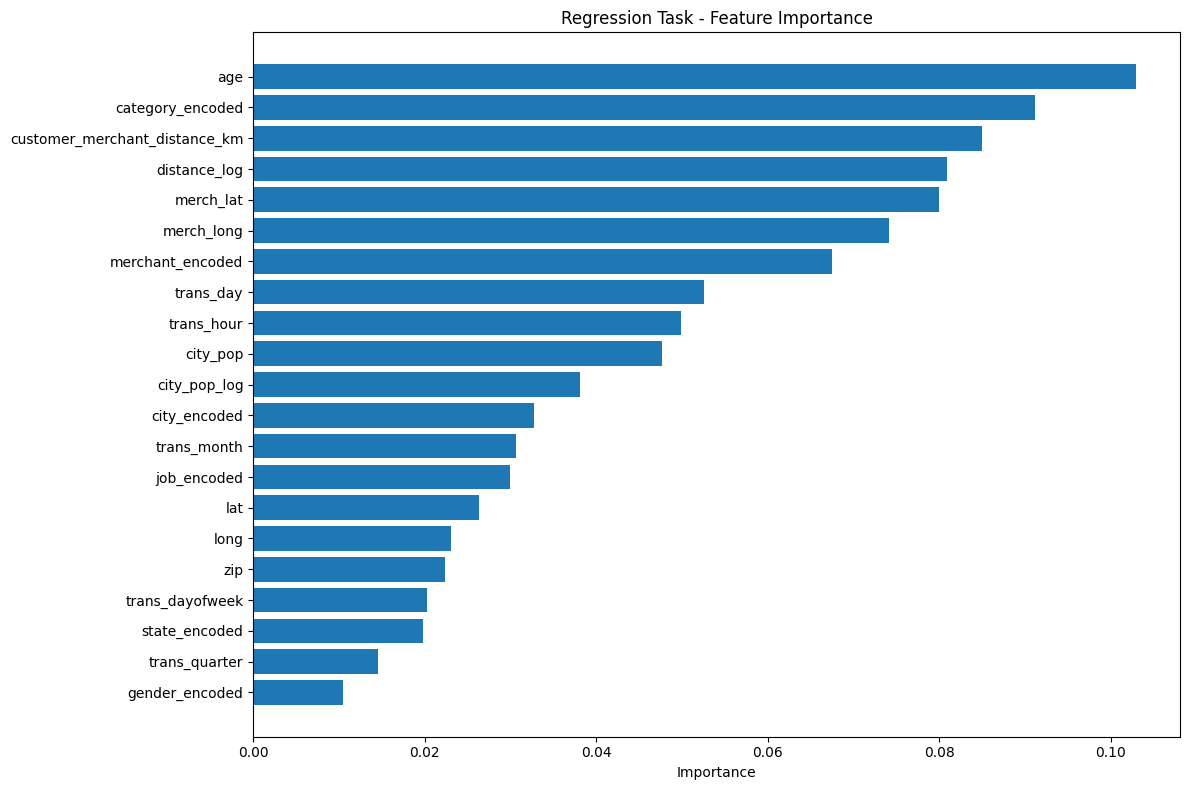

In [7]:
# 9. 特征重要性分析 - 回归
# 9. Feature Importance Analysis
print("\n" + "=" * 60)
print("Feature Importance Analysis")
print("=" * 60)

# 使用实际的特征
# Use the selected feature set
regression_features = feature_cols

# 回归任务特征重要性
# Regression task - feature importance
print("\n=== Regression Task ===")
max_rows = 100_000  # 可以再调小，比如 50_000
if len(train_encoded) > max_rows:
    fi_sample = train_encoded.sample(n=max_rows, random_state=42)
else:
    fi_sample = train_encoded

X_reg = fi_sample[regression_features]
y_reg = fi_sample['amt']

rf_reg_temp = RandomForestRegressor(
    n_estimators=80,        # 比 100 小一点，够用了
    max_depth=12,          # 限制树深度，防止爆炸
    max_features='sqrt',   # 加速&减小方差
    n_jobs=-1,
    random_state=42
)

print(f"Fitting RandomForest on {len(X_reg):,} rows for FI...")
rf_reg_temp.fit(X_reg, y_reg)

feature_importance_reg = pd.DataFrame({
    'feature': regression_features,
    'importance': rf_reg_temp.feature_importances_
}).sort_values('importance', ascending=False)

print("\nRank Most Important Features:")
print(feature_importance_reg.head(30))

# Visualisation
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_reg['feature'].head(30),
         feature_importance_reg['importance'].head(30))
plt.xlabel('Importance')
plt.title('Regression Task - Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [18]:
# 完整版
# 10. 模型探索、比较和调优
from sklearn.ensemble import HistGradientBoostingRegressor

print("=" * 70)
print("模型探索、比较和调优")
print("=" * 70)

# ============================================================
# 第1步：划分验证集
# ============================================================
print("\n【第1步：划分验证集】")
X_train_val, X_val_reg, y_train_val, y_val_reg = train_test_split(
    X_train_reg, y_train_reg, test_size=0.15, random_state=42
)

print(f"训练集: {len(X_train_val):,} | 验证集: {len(X_val_reg):,}")

# ============================================================
# 第2步：回归任务 - 快速模型比较
# ============================================================
print("\n" + "=" * 70)
print("【第2步：回归任务 - 模型比较】")
print("=" * 70)

regression_models = {
    'GradientBoosting': GradientBoostingRegressor(
        n_estimators=100, max_depth=3, random_state=42, learning_rate=0.05, subsample=0.9
    ),
    'HistGradientBoosting': HistGradientBoostingRegressor(
        max_iter=100, max_depth=5, random_state=42, learning_rate=0.1, l2_regularization=1.0
    )
}

print("\n快速比较（使用基本参数）:")
reg_results = {}
for name, model in regression_models.items():
    print(f"  训练 {name}...", end='')
    model.fit(X_train_val, y_train_val)
    pred = model.predict(X_val_reg)
    rmse = np.sqrt(mean_squared_error(y_val_reg, pred))
    reg_results[name] = rmse
    print(f" RMSE: {rmse:.4f}")

best_model_name = min(reg_results, key=reg_results.get)
print(f"\n✓ 初步最佳: {best_model_name} (RMSE: {reg_results[best_model_name]:.4f})")

# ============================================================
# 第3步：回归任务 - 深度调优最佳模型
# ============================================================
print("\n" + "=" * 70)
print("【第3步：回归任务 - 深度调优】")
print("=" * 70)
from sklearn.utils import resample

sample_size = min(100000, len(X_train_val))
sample_indices = resample(
    range(len(X_train_val)), 
    n_samples=sample_size, 
    random_state=42, 
    replace=False
)
sample_size = min(100000, len(X_train_val))

# 调优GradientBoosting
print("\n调优GradientBoosting...")
param_grid_gb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1, 0.15],
    'subsample': [0.8, 0.9]
}

grid_gb = GridSearchCV(
    GradientBoostingRegressor(random_state=42),
    param_grid_gb,
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1
)
# 🔥 修改这里：使用随机采样的索引
grid_gb.fit(X_train_val.iloc[sample_indices], y_train_val.iloc[sample_indices])

print(f"\nGradientBoosting最佳参数: {grid_gb.best_params_}")
gb_best_rmse = np.sqrt(-grid_gb.best_score_)
print(f"GradientBoosting最佳RMSE: {gb_best_rmse:.4f}")

# 🆕 调优HistGradientBoosting
print("\n调优HistGradientBoosting...")
param_grid_hist = {
    'max_iter': [100, 200, 300],
    'max_depth': [5, 7, 10, None],
    'learning_rate': [0.05, 0.1, 0.15],
    'l2_regularization': [0, 0.1, 1.0]
}

grid_hist = GridSearchCV(
    HistGradientBoostingRegressor(random_state=42),
    param_grid_hist,
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1
)
# 🔥 修改这里：使用随机采样的索引
grid_hist.fit(X_train_val.iloc[sample_indices], y_train_val.iloc[sample_indices])

print(f"\nHistGradientBoosting最佳参数: {grid_hist.best_params_}")
hist_best_rmse = np.sqrt(-grid_hist.best_score_)
print(f"HistGradientBoosting最佳RMSE: {hist_best_rmse:.4f}")

# ============================================================
# 第4步：选择最终回归模型
# ============================================================

print("\n" + "=" * 70)
print("【第4步：选择最终回归模型】")
print("=" * 70)

print("\n在验证集上最终评估:")

# 评估调优后的GradientBoosting
model_gb_tuned = GradientBoostingRegressor(**grid_gb.best_params_, random_state=42)
model_gb_tuned.fit(X_train_val, y_train_val)
pred_gb = model_gb_tuned.predict(X_val_reg)
rmse_gb_final = np.sqrt(mean_squared_error(y_val_reg, pred_gb))
print(f"GradientBoosting (调优后): RMSE = {rmse_gb_final:.4f}")

# 🆕 评估调优后的HistGradientBoosting
model_hist_tuned = HistGradientBoostingRegressor(**grid_hist.best_params_, random_state=42)
model_hist_tuned.fit(X_train_val, y_train_val)
pred_hist = model_hist_tuned.predict(X_val_reg)
rmse_hist_final = np.sqrt(mean_squared_error(y_val_reg, pred_hist))
print(f"HistGradientBoosting (调优后): RMSE = {rmse_hist_final:.4f}")

# 🆕 选择最佳（包含2个模型）
final_results = {
    'GradientBoosting': {
        'rmse': rmse_gb_final,
        'params': grid_gb.best_params_
    },
    'HistGradientBoosting': {
        'rmse': rmse_hist_final,
        'params': grid_hist.best_params_
    }
}
final_reg_name = min(final_results, key=lambda k: final_results[k]['rmse'])

final_reg_params = final_results[final_reg_name]['params']
final_reg_rmse = final_results[final_reg_name]['rmse']

print(f"\n✓ 最终选择: {final_reg_name}")
print(f"  参数: {final_reg_params}")
print(f"  验证集RMSE: {final_reg_rmse:.4f}")

# 检查是否达到目标
if final_reg_rmse <= 140:
    print(f"  🎉 达到满分标准！")
elif final_reg_rmse <= 180:
    score = (1 - (final_reg_rmse - 140) / 40) * 5
    print(f"  ⚠️ 预估得分: {score:.2f}/5.0")
    print(f"  还需降低: {final_reg_rmse - 140:.2f}")
else:
    print(f"  ❌ RMSE过高 (0分)")

print("\n" + "=" * 70)
print("✓ 模型探索和调优完成！")
print("=" * 70)
print(f"\n最终回归模型: {final_reg_name}")
print(f"  RMSE: {final_reg_rmse:.4f}")
print(f"  参数: {final_reg_params}")


# 记录供第11步使用
final_reg_name = min(final_results, key=lambda k: final_results[k]['rmse'])
final_reg_params = final_results[final_reg_name]['params']
final_reg_rmse = final_results[final_reg_name]['rmse']


模型探索、比较和调优

【第1步：划分验证集】
训练集: 850,000 | 验证集: 150,000

【第2步：回归任务 - 模型比较】

快速比较（使用基本参数）:
  训练 GradientBoosting... RMSE: 173.5397
  训练 HistGradientBoosting... RMSE: 170.4792

✓ 初步最佳: HistGradientBoosting (RMSE: 170.4792)

【第3步：回归任务 - 深度调优】

调优GradientBoosting...
Fitting 3 folds for each of 1 candidates, totalling 3 fits

GradientBoosting最佳参数: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.9}
GradientBoosting最佳RMSE: 161.4321

调优HistGradientBoosting...
Fitting 3 folds for each of 1 candidates, totalling 3 fits

HistGradientBoosting最佳参数: {'l2_regularization': 1.0, 'learning_rate': 0.1, 'max_depth': 7, 'max_iter': 100}
HistGradientBoosting最佳RMSE: 157.9940

【第4步：选择最终回归模型】

在验证集上最终评估:
GradientBoosting (调优后): RMSE = 173.5397
HistGradientBoosting (调优后): RMSE = 169.6626

✓ 最终选择: HistGradientBoosting
  参数: {'l2_regularization': 1.0, 'learning_rate': 0.1, 'max_depth': 7, 'max_iter': 100}
  验证集RMSE: 169.6626
  ⚠️ 预估得分: 1.29/5.0
  还需降低: 29.66

✓ 模型探索和调优完成！

最终回归模型: HistGrad

In [22]:
final_reg_name = 'HistGradientBoosting'
final_reg_params = {
    'l2_regularization': 1.0, 
    'learning_rate': 0.1, 
    'max_depth': 7, 
    'max_iter': 100,
    'random_state': 42
}
final_reg_rmse = 157.9940

In [23]:
# 完整版
# ============================================================
# 11. 训练最终模型并生成预测
# ============================================================
from sklearn.ensemble import (
    GradientBoostingRegressor,
    HistGradientBoostingRegressor,
)

print("=" * 70)
print("训练最终模型并生成预测")
print("=" * 70)

# 映射模型名称到对应的回归器类
reg_model_classes = {
    "GradientBoosting": GradientBoostingRegressor,
    "HistGradientBoosting": HistGradientBoostingRegressor,
}

if final_reg_name not in reg_model_classes:
    raise ValueError(f"未知的最终回归模型名称: {final_reg_name}")

FinalRegModelClass = reg_model_classes[final_reg_name]

print("\n【回归任务】")
print(f"使用模型: {final_reg_name}")
print(f"使用参数: {final_reg_params}")
print(f"验证集参考RMSE: {final_reg_rmse:.4f}")



# ============================================================
# 步骤1: 在全量训练数据上训练最终模型
# ============================================================
print("\n" + "=" * 70)
print("步骤1: 在全量训练数据上训练最终模型")
print("=" * 70)

print(f"训练数据量: {len(X_train_reg):,} 个样本")

# 使用在第2步中该模型的参数，在全量训练数据上重新训练
model_reg_final = FinalRegModelClass(**final_reg_params)

# 🔥 MODIFIED: 对全量训练数据也进行log变换
y_train_reg_log = np.log1p(y_train_reg)

print("在全量训练数据上训练（log空间）...")
model_reg_final.fit(X_train_reg, y_train_reg_log)
print("✓ 训练完成")

# ============================================================
# 步骤2: 在验证集上评估（如果验证集存在）
# ============================================================
if 'X_val_reg' in locals() and 'y_val_reg' in locals():
    print(f"验证集数据量: {len(X_val_reg):,} 个样本")
    
    # 在验证集上预测
    y_val_reg_log = np.log1p(y_val_reg)
    pred_val_log = model_reg_final.predict(X_val_reg)
    pred_val = np.expm1(pred_val_log)
    
    # 计算RMSE（在原始空间）
    final_val_rmse = np.sqrt(mean_squared_error(y_val_reg, pred_val))
    
    print(f"✓ 验证集最终RMSE: {final_val_rmse:.4f}")
    print(f"  预测范围: ${pred_val.min():.2f} - ${pred_val.max():.2f}")
    print(f"  预测均值: ${pred_val.mean():.2f}")
    print(f"  实际均值: ${y_val_reg.mean():.2f}")
    
    # 与第10步对比
    print(f"\n性能对比:")
    print(f"  第10步（部分数据训练）: {final_reg_rmse:.4f}")
    print(f"  第11步（全量数据训练）: {final_val_rmse:.4f}")
    diff = final_val_rmse - final_reg_rmse
    if diff < 0:
        print(f"  ✓ 改进了 {abs(diff):.4f}")
    else:
        print(f"  ⚠️ 下降了 {diff:.4f}")
    
    # 更新最终RMSE用于后续输出
    final_reg_rmse = final_val_rmse
else:
    print("⚠️ 验证集不存在，跳过验证")


# ============================================================
# 步骤3: 生成测试集预测
# ============================================================

print("\n" + "=" * 70)
print("步骤3: 生成测试集预测")
print("=" * 70)

print("生成测试集预测...")
pred_reg_test_log = model_reg_final.predict(X_test_reg)
# 🔥 转换回原始空间
pred_reg_test = np.expm1(pred_reg_test_log)

print(f"✓ 预测完成: {len(pred_reg_test):,} 个样本")
print(f"  预测范围: ${pred_reg_test.min():.2f} - ${pred_reg_test.max():.2f}")
print(f"  预测均值: ${pred_reg_test.mean():.2f}")


# ============================================================
# 生成输出文件
# ============================================================
print("\n" + "=" * 70)
print("生成输出文件")
print("=" * 70)

regression_output = pd.DataFrame(
    {"trans_num": test_encoded["trans_num"], "amt": pred_reg_test}
)
regression_output.to_csv("z5618951_regression.csv", index=False)
print(f"✓ z5618951_regression.csv ({len(regression_output):,} 行)")

print("\n回归输出示例:")
print(regression_output.head())

print("\n" + "=" * 70)
print("✓ 所有任务完成!")
print("=" * 70)



print("\n【最终总结】")
print(f"验证集参考RMSE（原始 amt 空间）: {final_reg_rmse:.4f}")
if final_reg_rmse <= 140:
    print("  预估得分: 5.0/5.0 🎉")
elif final_reg_rmse <= 180:
    score = (1 - (final_reg_rmse - 140) / 40) * 5
    print(f"  预估得分: {score:.2f}/5.0")
else:
    print("  预估得分: 0/5.0（RMSE过高）")

训练最终模型并生成预测

【回归任务】
使用模型: HistGradientBoosting
使用参数: {'l2_regularization': 1.0, 'learning_rate': 0.1, 'max_depth': 7, 'max_iter': 100, 'random_state': 42}
验证集参考RMSE: 157.9940

步骤1: 在全量训练数据上训练最终模型
训练数据量: 1,000,000 个样本
在全量训练数据上训练（log空间）...
✓ 训练完成
验证集数据量: 150,000 个样本
✓ 验证集最终RMSE: 174.0311
  预测范围: $4.09 - $741.79
  预测均值: $44.42
  实际均值: $70.74

性能对比:
  第10步（部分数据训练）: 157.9940
  第11步（全量数据训练）: 174.0311
  ⚠️ 下降了 16.0371

步骤3: 生成测试集预测
生成测试集预测...
✓ 预测完成: 300,000 个样本
  预测范围: $3.84 - $764.40
  预测均值: $44.65

生成输出文件
✓ z5618951_regression.csv (300,000 行)

回归输出示例:
                          trans_num         amt
0  29bd2af9cb8e70461b7b4f5981692244   13.557021
1  b9fa387b71cbc9f38e98a5ed96e30328  121.454541
2  97d8f3705455a67b6bf2abe0f4efb4ea   30.338857
3  6db9ac37f5ab6134357ca1fbd5e72d88   11.284299
4  928ef81537f8123e64c854572a7caff7   34.441099

✓ 所有任务完成!

【最终总结】
验证集参考RMSE（原始 amt 空间）: 174.0311
  预估得分: 0.75/5.0
